In [20]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colors
import librosa
import IPython.display as ipd
import copy

from utils.plot_tools import *
from utils.feature_tools import normalize_feature_sequence
from utils.structure_tools import read_structure_annotation, convert_ann_to_seq_label

# 템플릿-기반 화음 인식 Template-Based Chord Recognition

- 음악에서 **하모니(harmony)** 는 서로 다른 음이 동시에 나는 소리를 의미한다. 하모니의 주요 구성 요소는 음악적 구조인 **화음/코드(chords)** 이며, 일반적으로 세 개 이상의 음으로 구성된다. 화음 분석은 화음의 구성, 상호 작용 및 진행에 대한 연구로 생각할 수 있다. 
- 이 노트북에서는 **화음 인식(chord recognition)** 이라고 하는 화음 분석의 하위 문제에 대해 논의한다. 여기서는 가장 중요한 소수의 화음만 고려한다. 
- 또한 **오디오 녹음**의 형태로 음악이 제공된다고 가정한다. 그 결과 화음 인식 작업은 녹음을 **세그먼트**로 분할하고 **화음 라벨(label)** 을 각 세그먼트에 할당하는 것으로 구성된다. 
- 분할은 화음의 시작 및 종료 시간을 지정하고 화음 라벨은 이 기간 동안 연주되는 화음을 지정한다. 일반적인 화음 인식 시스템은 **두 가지 주요 단계**로 구성된다.
    * 첫 번째 단계에서, 주어진 오디오 녹음을 프레임으로 자르고 각 프레임을 적절한 **특징 벡터(feature vector)** 로 변환한다. 대부분의 인식 시스템은 **크로마 기반 오디오 피처**에 의존하며 이는 오디오 신호에 포함된 기본 톤 정보와 관련된다.
    * 두 번째 단계에서, **패턴 일치(pattern matching)** 기술을 사용하여 각 특징 벡터를 미리 정의된 **화음 모형(chord model)** 집합에 매핑한다. 최적 fit은 주어진 프레임에 할당된 화음 라벨을 결정한다.

- 화음 인식 결과를 향상시키기 위해 패턴 매칭 단계 전 **prefiltering** 또는 패턴 매칭 단계 후/내에서 **postfiltering**을 통해 추가 향상 기술이 적용된다.


- 이 노트북에서는 간단한 템플릿 기반 매칭 전략을 사용하는 첫 번째 화음 인식 절차를 소개한다.

- 이 챕터에서는 비틀즈의 Let It Be의 첫부분을 예시 음악으로 한다.

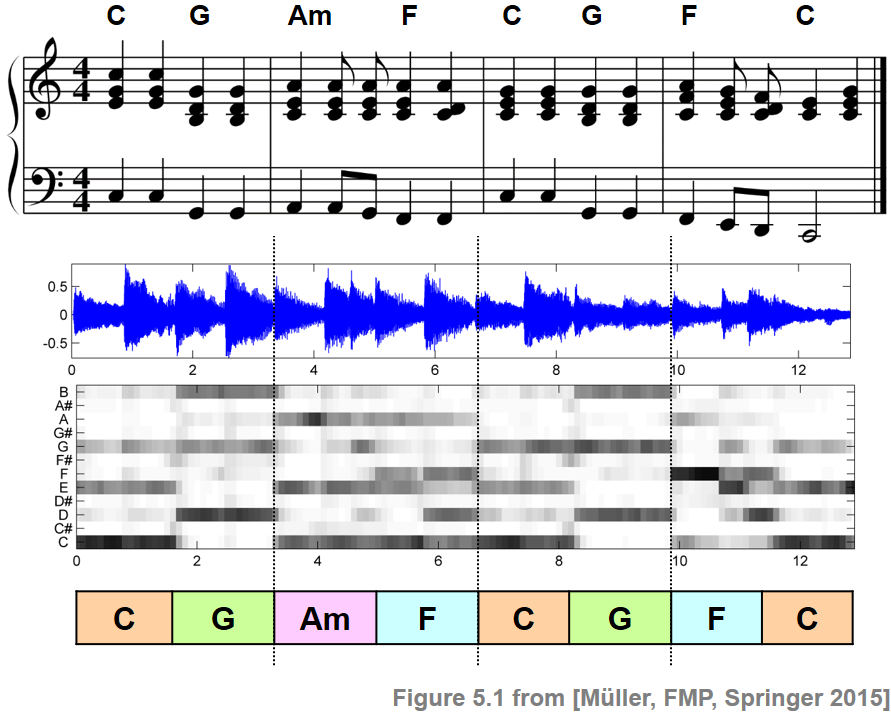

In [2]:
ipd.display(ipd.Image("../img/6.chord_recognition/FMP_C5_F01.png", width=500))
ipd.display(ipd.Audio("../data_FMP/FMP_C5_F01_Beatles_LetItBe-mm1-4_Original.wav"))

## 크로마-기반 특징 표현 (Chroma-Based Feature Representation)

- 음악의 오디오 녹음이 주어지면 첫 번째 단계는 녹음을 특징 벡터 $x_n\in\mathcal{F}$, $n\in[1:N]$의 시퀀스 $X=(x_1,x_2,\ldots,x_N)$로 바꾸는 것이다. 
- 위에서 언급한 것처럼 거의 모든 전통적인 화음(이하 코드) 인식 절차는 **크로마 기반 특징 표현** 유형에 의존한다.
- 이는 크로마 기반 특징이 신호의 단시간의 톤 내용을 캡처하기 때문이며, 이는 기본 곡의 하모니 진행과 밀접하게 관련되어 있다.
- 평균율 음계를 가정하면 크로마 값은 집합 $\{\mathrm{C},\mathrm{C}^\sharp,\mathrm{D},\ldots,\mathrm{B}\}$에 해당하며 집합 $[0:11]$로 식별한다. 
- 크로마 특징은 $12$차원 벡터로 표현될 수 있다.
$$
x=(x(0),x(1),\ldots,x(11))^\top\in\mathcal{F}=\mathbb{R}^{12}
$$

- 크로마 특징을 계산하는 여러 많은 방법이 있다. 또한 그 속성은 적당한 후처리(postprocessing) 과정(예: 로그 컴프레션, 정규화, 스무딩)을 통해 조정될 수 있다. 
- 다음에서 세개의 크로마 특징 방법을 보기로 한다.
    * STFT-based chroma features (`librosa.feature.chroma_stft`). 
    * Filter-bank decomposition using IIR elliptic filters (`librosa.iirt`), logarithmic compression, and chroma binning.
    * CQT-based chroma features (`librosa.feature.chroma_cqt`)

- 각 변형에 대해 동일한 창(window) 길이(`N=4096`)와 홉(hop) 크기(`H=2048`)를 사용한다. 또한 각 변형에서 유클리드 norm($\ell^2$-norm)에 대해 크로마 벡터를 정규화한다.

In [3]:
def compute_chromagram_from_filename(fn_wav, Fs=22050, N=4096, H=2048, gamma=None, version='STFT', norm='2'):
    """Compute chromagram for WAV file specified by filename

    Args:
        fn_wav (str): Filenname of WAV
        Fs (scalar): Sampling rate (Default value = 22050)
        N (int): Window size (Default value = 4096)
        H (int): Hop size (Default value = 2048)
        gamma (float): Constant for logarithmic compression (Default value = None)
        version (str): Technique used for front-end decomposition ('STFT', 'IIS', 'CQT') (Default value = 'STFT')
        norm (str): If not 'None', chroma vectors are normalized by norm as specified ('1', '2', 'max')
            (Default value = '2')

    Returns:
        X (np.ndarray): Chromagram
        Fs_X (scalar): Feature reate of chromagram
        x (np.ndarray): Audio signal
        Fs (scalar): Sampling rate of audio signal
        x_dur (float): Duration (seconds) of audio signal
    """
    x, Fs = librosa.load(fn_wav, sr=Fs)
    x_dur = x.shape[0] / Fs
    if version == 'STFT':
        # Compute chroma features with STFT
        X = librosa.stft(x, n_fft=N, hop_length=H, pad_mode='constant', center=True)
        if gamma is not None:
            X = np.log(1 + gamma * np.abs(X) ** 2)
        else:
            X = np.abs(X) ** 2
        X = librosa.feature.chroma_stft(S=X, sr=Fs, tuning=0, norm=None, hop_length=H, n_fft=N)
    if version == 'CQT':
        # Compute chroma features with CQT decomposition
        X = librosa.feature.chroma_cqt(y=x, sr=Fs, hop_length=H, norm=None)
    if version == 'IIR':
        # Compute chroma features with filter bank (using IIR elliptic filter)
        X = librosa.iirt(y=x, sr=Fs, win_length=N, hop_length=H, center=True, tuning=0.0)
        if gamma is not None:
            X = np.log(1.0 + gamma * X)
        X = librosa.feature.chroma_cqt(C=X, bins_per_octave=12, n_octaves=7,
                                       fmin=librosa.midi_to_hz(24), norm=None)
    if norm is not None:
        X = normalize_feature_sequence(X, norm='2')
    Fs_X = Fs / H
    return X, Fs_X, x, Fs, x_dur


def plot_chromagram_annotation(ax, X, Fs_X, ann, color_ann, x_dur, cmap='gray_r', title=''):
    """Plot chromagram and annotation

    Args:
        ax: Axes handle
        X: Feature representation
        Fs_X: Feature rate
        ann: Annotations
        color_ann: Color for annotations
        x_dur: Duration of feature representation
        cmap: Color map for imshow (Default value = 'gray_r')
        title: Title for figure (Default value = '')
    """
    plot_chromagram(X, Fs=Fs_X, ax=ax,
                             chroma_yticks=[0, 2, 4, 7, 9, 11], clim=[0, 1], cmap=cmap,
                             title=title, ylabel='Chroma', colorbar=True)
    plot_segments_overlay(ann, ax=ax[0], time_max=x_dur,
                                   print_labels=False, colors=color_ann, alpha=0.1)

In [4]:
# Compute chroma features
fn_wav = '../data_FMP/FMP_C5_F01_Beatles_LetItBe-mm1-4_Original.wav'
N = 4096
H = 2048
X_STFT, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')
X_IIR, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=100, version='IIR')
X_CQT, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, version='CQT')

# Annotations
fn_ann = '../data_FMP/FMP_C5_F01_Beatles_LetItBe-mm1-4_Original_Chords_simplified.csv'
ann, _ = read_structure_annotation(fn_ann)
color_ann = {'N': [1, 1, 1, 1], 'C': [1, 0.5, 0, 1], 'G': [0, 1, 0, 1], 
             'Am': [1, 0, 0, 1], 'F': [0, 0, 1, 1]}

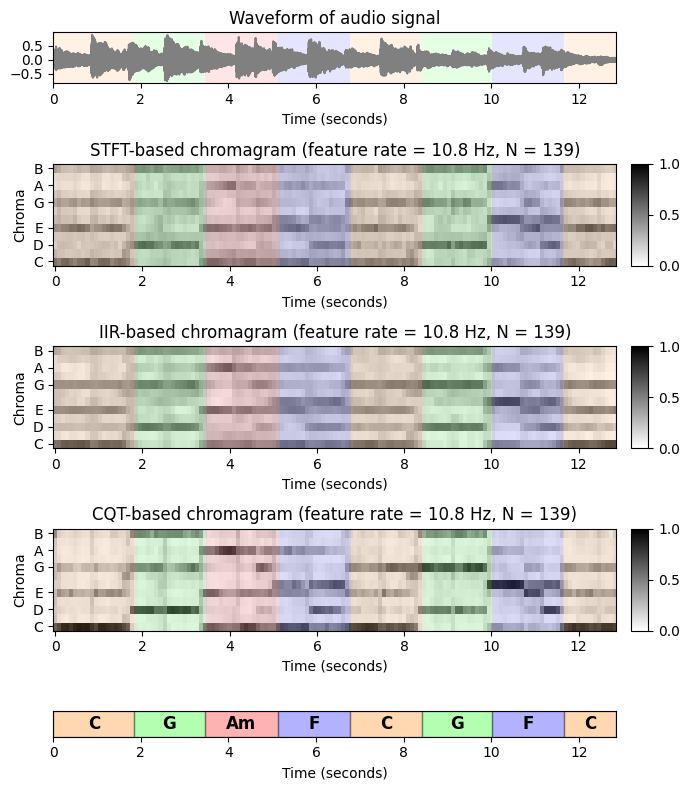

In [5]:
# Plot
cmap = compressed_gray_cmap(alpha=1, reverse=False)
fig, ax = plt.subplots(5, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1, 2, 2, 2, 0.5]}, figsize=(7, 8))
plot_signal(x, Fs, ax=ax[0,0], title='Waveform of audio signal')
plot_segments_overlay(ann, ax=ax[0,0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)
ax[0,1].axis('off')

title = 'STFT-based chromagram (feature rate = %0.1f Hz, N = %d)'%(Fs_X, X_STFT.shape[1])
plot_chromagram_annotation([ax[1, 0], ax[1, 1]], X_STFT, Fs_X, ann, color_ann, x_dur, title=title)

title = 'IIR-based chromagram (feature rate = %0.1f Hz, N = %d)'%(Fs_X, X_IIR.shape[1])
plot_chromagram_annotation([ax[2, 0], ax[2, 1]], X_IIR, Fs_X, ann, color_ann, x_dur, title=title)

title = 'CQT-based chromagram (feature rate = %0.1f Hz, N = %d)'%(Fs_X, X_CQT.shape[1])
plot_chromagram_annotation([ax[3, 0], ax[3, 1]], X_CQT, Fs_X, ann, color_ann, x_dur, title=title)

plot_segments(ann, ax=ax[4, 0], time_max=x_dur, time_label='Time (seconds)',
              colors=color_ann,  alpha=0.3)
ax[4,1].axis('off')
plt.tight_layout()

## 템플릿-기반 패턴 매칭 (Template-Based Pattern Matching)

- 크로마 시퀀스 $X=(x_1,x_2,\ldots,x_N)$ 및 가능한 코드 라벨(chord label)의 집합 $\Lambda$가 주어지면, 다음 단계의 목적은 각 크로마 벡터 $x_n\in\mathbb{R}^{12}$을 코드 라벨 $\lambda_{n} \in \Lambda$, $n\in[1:N]$에 매핑하는 것이다.

- 예를 들어 12개의 장3화음과 12개의 단3화음으로 구성된 집합을 생각할 수 있다.
    - $\Lambda = \{\mathbf{C},\mathbf{C}^\sharp,\ldots,\mathbf{B},\mathbf{Cm},\mathbf{C^\sharp m},\ldots,\mathbf{Bm}\}$

- 이 경우 각 프레임 $n\in[1:N]$은 $\lambda_{n}$로 지정된 메이저 코드(=장화음) 또는 마이너 코드(=단화음)에 할당된다. 패턴 매칭 단계를 위해 이제 간단한 템플릿 기반 접근 방식을 도입해보자. 

- 집합 $\mathcal{T}\subset\mathcal{F}=\mathbb{R}^{12}$를 미리 계산한다. ($\mathbf{t}_\lambda\in\mathcal{T}$, $\lambda\in\Lambda$)

- 직관적으로 각 템플릿은 특정 화음을 나타내는 원형(prototypical) 크로마 벡터로 생각할 수 있다. 

- 또한 서로 다른 크로마 벡터를 비교할 수 있도록 다음의 유사성 측정을 고정한다.
    - $s:\mathcal{F}\times\mathcal{F}\to \mathbb{R}$

- 그 다음 해당 템플릿과 주어진 특징 벡터 $x_n$ 사이의 유사성을 최대화하는 코드 라벨을 할당한다.
\begin{equation}
        \lambda_{n} := \underset{\lambda \in \Lambda}{\mathrm{argmax}}
         \,\, s( \mathbf{t}_\lambda , x_n ).
\end{equation}

- 이 절차에는 화음 인식의 성능에 결정적으로 영향을 미치는 많은 선택 사항이 있다.
    * $\mathcal{T}$에서 어떤 화음을 고려해야 하는가?
    * 화음 템플릿은 어떻게 정의되는가?
    * 특징 벡터와 화음 템플릿을 비교하기 위한 적절한 유사도 측정은 무엇인가?
    
- 첫 번째 간단한 화음 인식 시스템을 얻기 위해 다음과 같은 설계 선택을 한다. 
- 화음 라벨의 집합 $\Lambda$에 대해 12개의 장3화음과 12개의 단3화음을 선택한다. 이 선택은 음악적 관점에서 문제가 있을 수 있으나 편리하고 유익하다. Enharmonic equivalence 및 옥타브 이동의 화음을 고려하면, 각 3화음은 $[0:11]$의 3개 요소 하위 집합으로 인코딩될 수 있다. 
- 예를 들어, $\mathrm{C}$-major 화음 $\mathbf{C}$는 하위집합 $\{0,4,7\}$에 해당한다. 차례로 각 하위 집합은 이진 12차원 크로마 벡터 $x=(x(0),x(1),\ldots,x(11))^\top$로 식별할 수 있다. 여기서 $x(i) =1$ iff 크로마 값 $i\in[0:11]$이 화음에 포함된 경우.
- $\mathrm{C}$-major 화음 $\mathbf{C}$의 경우 결과 크로마 벡터는 다음과 같다.
    - $ \label{eq:ChordReco:Template:Basic:ChromaVectC}
     \mathbf{t}_{\mathbf{C}}{} := x =(1,0,0,0,1,0,0,1,0,0,0,0)^\top. $

- 크로마 기반 인코딩을 사용하여 $\mathrm{C}$-major 및 $\mathrm{C}$-minor 3화음에 대한 이진 벡터를 각각 순환 이동(cyclically shitfting)하여 12개의 메이저 코드 및 12개의 마이너 코드를 얻을 수 있다.

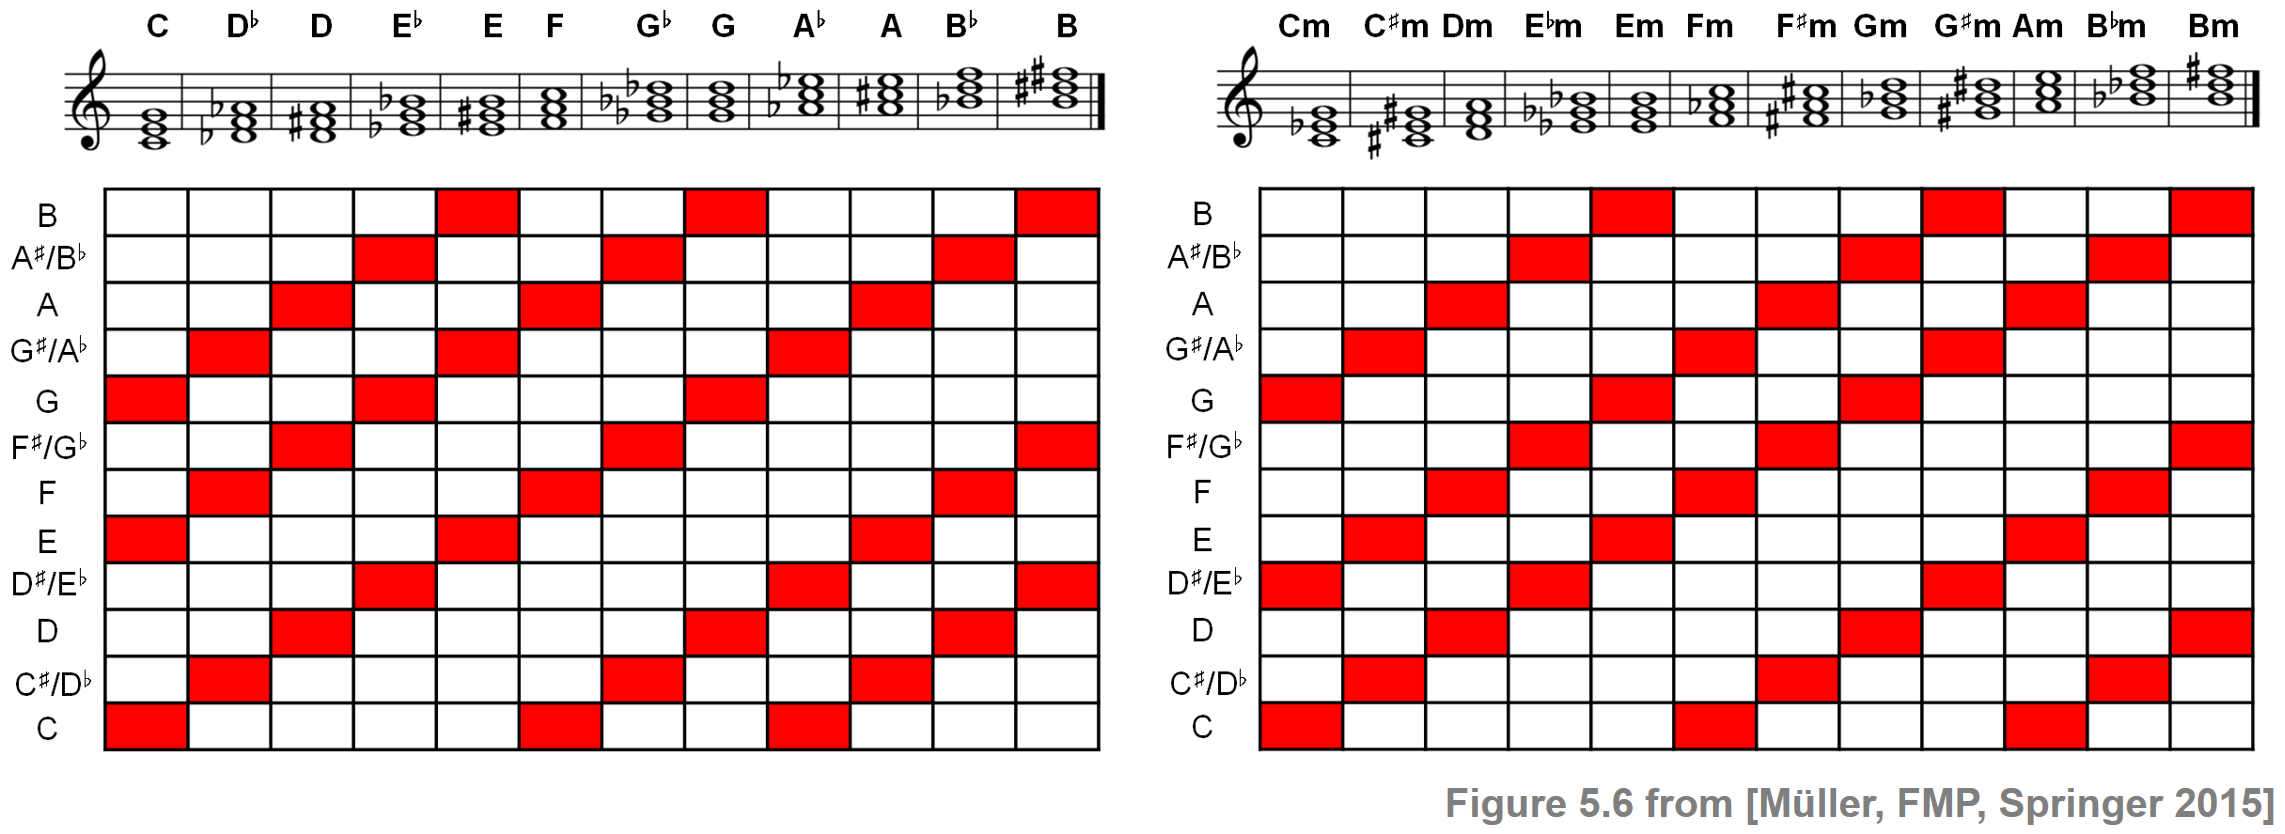

In [6]:
ipd.Image("../img/6.chord_recognition/FMP_C5_F06.png", width=800)

- 크로마 특징과 화음 템플릿을 비교하기 위해 정규화된 벡터의 내적을 사용한 다음과 같은 간단한 유사성 측정을 사용한다.
    - $ s(x,y)= \frac{\langle x,y\rangle}{\|x\|\cdot\|y\|}$
    - for $x,y\in\mathcal{F}$ with  $\|x\|\not= 0$ and $\|y\|\not= 0$
- $\|x\|=0$ 또는 $\|y\|=0$인 경우, $s(x,y)=0$로 설정한다. 이 측정값은 항상 $s(x,y)\in[-1,1]$ 값을 산출하며, 벡터 $x$ 및 $y$에 양수 항목만 있는 경우 하나는 $s(x,y)\in[0,1]$이다.

## Implementation

- 다음 코드 셀에서 앞에서 설명한 템플릿 기반 코드 인식 절차를 구현한다. 
     * 먼저 오디오 녹음이 크로마 표현으로 변환된다. 예를 들어 STFT 변형을 사용한다.
     * 둘째, 각 크로마 벡터는 각 $24$ 이진 화음 템플릿과 비교되어 프레임당 $24$ 유사성 값을 생성한다. 이러한 유사성 값은 **time-chord 표현**의 형태로 시각화된다.
     * 셋째, 모든 $24$개 화음 템플릿에 대해 유사성 값을 최대화하는 템플릿의 화음 라벨 $\lambda_{n}$를 각 프레임에 대해 선택한다. 이것은 **이진 time-chord 표현**의 형태로 표시되는 최종 화음 인식 결과를 산출한다.
     * 넷째, 수동으로 생성된 화음 주석(annotation)이 시각화된다.

In [7]:
def get_chord_labels(ext_minor='m', nonchord=False):
    """Generate chord labels for major and minor triads (and possibly nonchord label)

    Args:
        ext_minor (str): Extension for minor chords (Default value = 'm')
        nonchord (bool): If "True" then add nonchord label (Default value = False)

    Returns:
        chord_labels (list): List of chord labels
    """
    chroma_labels = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']
    chord_labels_maj = chroma_labels
    chord_labels_min = [s + ext_minor for s in chroma_labels]
    chord_labels = chord_labels_maj + chord_labels_min
    if nonchord is True:
        chord_labels = chord_labels + ['N']
    return chord_labels


def generate_chord_templates(nonchord=False):
    """Generate chord templates of major and minor triads (and possibly nonchord)

    Args:
        nonchord (bool): If "True" then add nonchord template (Default value = False)

    Returns:
        chord_templates (np.ndarray): Matrix containing chord_templates as columns
    """
    template_cmaj = np.array([1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0]).T
    template_cmin = np.array([1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0]).T
    num_chord = 24
    if nonchord:
        num_chord = 25
    chord_templates = np.ones((12, num_chord))
    for shift in range(12):
        chord_templates[:, shift] = np.roll(template_cmaj, shift)
        chord_templates[:, shift+12] = np.roll(template_cmin, shift)
    return chord_templates


def chord_recognition_template(X, norm_sim='1', nonchord=False):
    """Conducts template-based chord recognition
    with major and minor triads (and possibly nonchord)

    Args:
        X (np.ndarray): Chromagram
        norm_sim (str): Specifies norm used for normalizing chord similarity matrix (Default value = '1')
        nonchord (bool): If "True" then add nonchord template (Default value = False)

    Returns:
        chord_sim (np.ndarray): Chord similarity matrix
        chord_max (np.ndarray): Binarized chord similarity matrix only containing maximizing chord
    """
    chord_templates = generate_chord_templates(nonchord=nonchord)
    X_norm = normalize_feature_sequence(X, norm='2')
    chord_templates_norm = normalize_feature_sequence(chord_templates, norm='2')
    chord_sim = np.matmul(chord_templates_norm.T, X_norm)
    if norm_sim is not None:
        chord_sim = normalize_feature_sequence(chord_sim, norm=norm_sim)
    # chord_max = (chord_sim == chord_sim.max(axis=0)).astype(int)
    chord_max_index = np.argmax(chord_sim, axis=0)
    chord_max = np.zeros(chord_sim.shape).astype(np.int32)
    for n in range(chord_sim.shape[1]):
        chord_max[chord_max_index[n], n] = 1

    return chord_sim, chord_max

In [8]:
# Chord recognition
X = X_STFT
chord_sim, chord_max = chord_recognition_template(X, norm_sim='max')
chord_labels = get_chord_labels(nonchord=False)

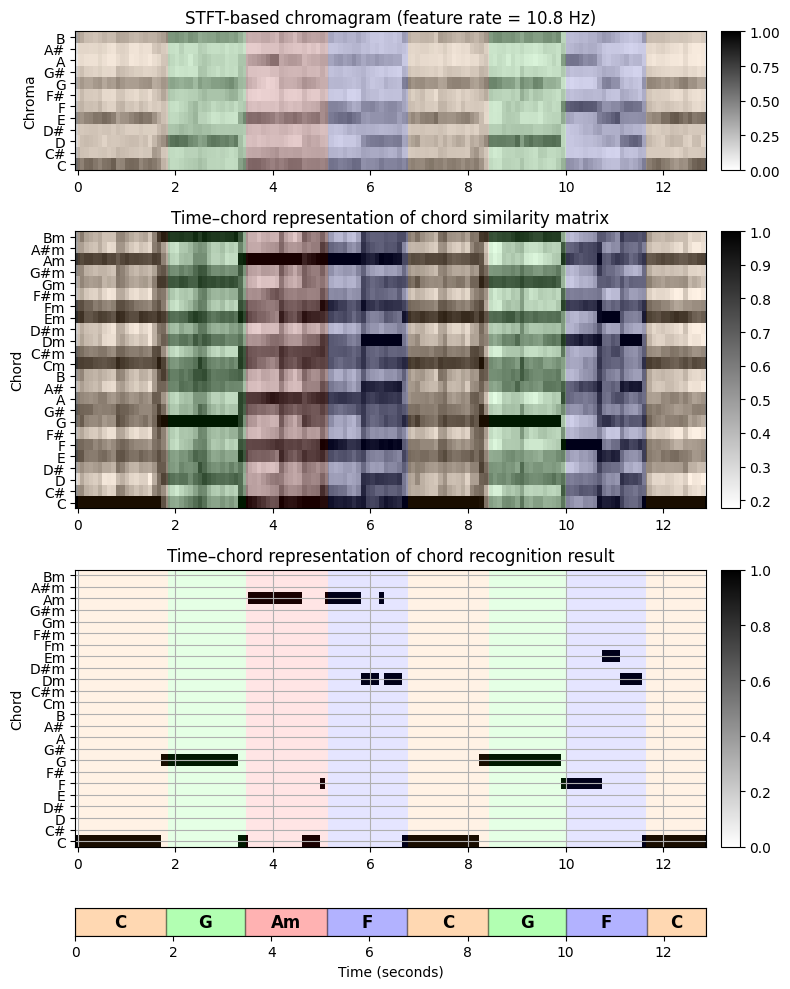

In [9]:
# Plot
cmap = compressed_gray_cmap(alpha=1, reverse=False)
fig, ax = plt.subplots(4, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1.5, 3, 3, 0.3]}, figsize=(8, 10))
plot_chromagram(X, ax=[ax[0,0], ax[0,1]], Fs=Fs_X, clim=[0, 1], xlabel='',
                         title='STFT-based chromagram (feature rate = %0.1f Hz)' % (Fs_X))
plot_segments_overlay(ann, ax=ax[0,0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

plot_matrix(chord_sim, ax=[ax[1, 0], ax[1, 1]], Fs=Fs_X, 
                     title='Time–chord representation of chord similarity matrix',
                     ylabel='Chord', xlabel='')
ax[1, 0].set_yticks(np.arange( len(chord_labels) ))
ax[1, 0].set_yticklabels(chord_labels)
plot_segments_overlay(ann, ax=ax[1, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

plot_matrix(chord_max, ax=[ax[2, 0], ax[2, 1]], Fs=Fs_X, 
                     title='Time–chord representation of chord recognition result',
                     ylabel='Chord', xlabel='')
ax[2, 0].set_yticks(np.arange( len(chord_labels) ))
ax[2, 0].set_yticklabels(chord_labels)
ax[2, 0].grid()
plot_segments_overlay(ann, ax=ax[2, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

plot_segments(ann, ax=ax[3, 0], time_max=x_dur, time_label='Time (seconds)',
                       colors=color_ann,  alpha=0.3)
ax[3, 1].axis('off')
plt.tight_layout()

- time-chord 표현 형태로 표시된 화음 유사도 값은 각 크로마 벡터에 대해 가능한 $24$개 화음에 대한 일종의 우도(likelihood)를 나타낸다.
- 예를 들어 노래의 시작 부분에 있는 크로마 벡터가 $\mathrm{C}$-major 코드 $\mathbf{C}$의 템플릿과 가장 유사하다는 것을 보여준다. 또한 $\mathbf{C}$, $\mathbf{Em}$ 및 $\mathbf{Am}$에 대한 템플릿과의 유사성도 더 높다.
- 최종 화음 인식 결과를 참조 주석과 비교하면 자동화된 절차에서 얻은 결과가 대부분의 프레임에 대한 참조 라벨과 일치함을 관찰할 수 있다.

- 마지막으로 각 프레임에 대한 유사성-최대화 코드 템플릿을 살펴본다. 이렇게 하면 원래 입력 크로마그램과 비교할 수 있는 time-chroma 표현이 생성된다. 어떤 면에서는 화음 템플릿의 시퀀스는 입력 크로마 표현의 음악적 정보를 바탕으로 한 양자화(quantization)로 생각할 수 있다.

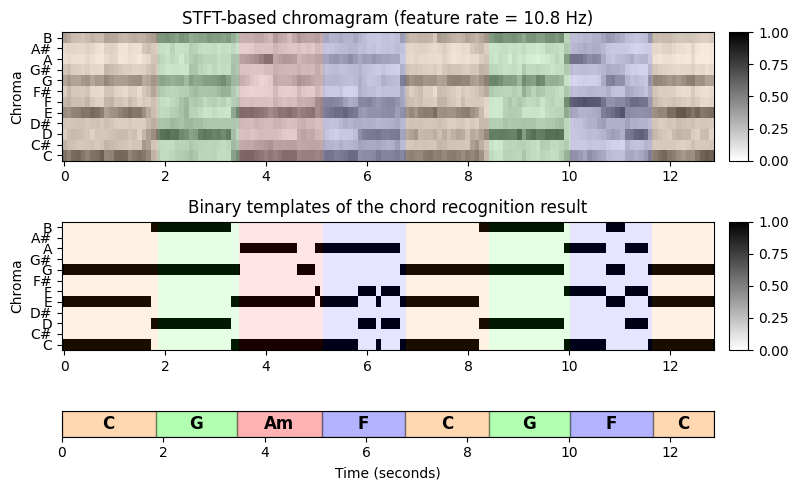

In [10]:
chord_templates = generate_chord_templates() 
X_chord = np.matmul(chord_templates, chord_max)

# Plot
fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1, 1, 0.2]}, figsize=(8, 5))

plot_chromagram(X, ax=[ax[0, 0], ax[0, 1]], Fs=Fs_X, clim=[0, 1], xlabel='',
                         title='STFT-based chromagram (feature rate = %0.1f Hz)' % (Fs_X))
plot_segments_overlay(ann, ax=ax[0, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

plot_chromagram(X_chord, ax=[ax[1, 0], ax[1, 1]], Fs=Fs_X, clim=[0, 1], xlabel='',
                         title='Binary templates of the chord recognition result')
plot_segments_overlay(ann, ax=ax[1, 0], time_max=x_dur,
                               print_labels=False, colors=color_ann, alpha=0.1)

plot_segments(ann, ax=ax[2, 0], time_max=x_dur, time_label='Time (seconds)',
                       colors=color_ann,  alpha=0.3)
ax[2,1].axis('off')
plt.tight_layout()

# 화음 인식 평가 (Chord Recognition Evaluation)

- 화음 인식 절차의 품질을 평가하기 위한 일반적인 접근 방식은 계산된 결과를 **참조 주석(reference annotation)** 과 비교하는 것이다. 그러나 그러한 평가는 종종 다양한 질문을 야기한다.
    * 계산된 결과와 참조 주석 간의 일치는 어떻게 정량화 해야 하는가? 
    * 참조 주석이 잘 정의되어 있으며 신뢰할 수 있는가?
    * 화음 인식 작업의 형식화에서 모델 가정이 적절한가?
    * 이러한 가정을 위반하면 최종 결과에 어느 정도 영향을 미치는가?

- 이 모든 질문에 대한 명확한 답변은 없으며, 평가 결과를 신중하게 검토해야 한다. 

- **ground truth**라고도 하는 **참조 주석**이 있다고 가정한다. 일반적으로 이러한 참조 주석은 종종 악보 표현을 기반으로 음악 전문가가 생성한다. 그러나 일반적으로 잘 정의된 실측은 존재하지 않으며 음악 전문가도 주어진 주석에 대해 동의하지 않을 수 있다. 또한, 주석은 사용된 시간적 세분성(예: 음표, 비트, 소절 또는 구간 레벨)에 따라 달라질 수 있다. 또한 계산된 결과와 비교할 수 있도록 주석을 조정해야 한다.

## Accuracy, Precision, Recall, F-Measure

- 크로마 시퀀스 $X=(x_1,x_2,\ldots,x_N)$와 가능한 화음 라벨 집합 $\Lambda := \{\mathbf{C},\mathbf{C}^\sharp,\ldots,\mathbf{B}, \mathbf{Cm}, \mathbf{Cm^\sharp}, \ldots,\mathbf{Bm}\}$가 주어졌을 때, 템플릿-기반 화음 잇기의 결과물은 각 프레임 $n\in[1:N]$에 대한 화음 라벨 $\lambda_{n}\in\Lambda$이었다. 또한 프레임 방식 $\lambda^\mathrm{Ref}_{n}\in\Lambda$ for $n\in[1:N]$로도 지정되는 참조 주석이 제공된다고 가정한다.

- 그러나 모든 프레임에 주석을 달아야 한다고 가정할 필요는 없다. 예를 들어, 녹음이 묵음으로 시작하거나 박수로 끝나는 경우 이러한 구간에 대한 의미 있는 화음 주석이 없으며 해당 프레임은 평가에서 고려되지 않은 상태로 두어야 한다. 
- 이를 모델링하기 위해 **non-chord label**을 나타내는 추가 기호 $\mathbf{N}$로 라벨 집합을 확장한다. 따라서 새 라벨의 집합에는 $25$개 원소가 있으며 다음과 같이 정의된다.
    - $ \Lambda':= \Lambda \cup  \{\mathbf{N}\}$

- 다음에서 참조 주석은 라벨 $\lambda^\mathrm{Ref}_{n}\in\Lambda'$ for $n\in[1:N]$ 로 주어진다. 또한, $\lambda_{n}\in\Lambda'$ for $n\in[1:N]$를 가정한다. 즉, non-chord 라벨도 출력할 수 있다(예: 모든 유사성이 크로마 프레임과 템플릿 사이의 값이 특정 임계값 미만). 

- 그런 다음 계산된 라벨 $\lambda_{n}$을 참조 라벨 $\lambda^\mathrm{Ref}_{n}$와 비교하여 프레임 단위로 평가를 수행할 수 있다. 주어진 프레임 $\lambda_{n}=\lambda^\mathrm{Ref}_{n}$ for $n\in[1:N]$인 경우 화음 인식 접근 방식에 의해 예측된 라벨이 **correct**하다고 말한다.  그렇지 않으면 **incorrect**한 것으로 간주된다. 


- **정확도(accuracy)** $\mathrm{A}$는 올바르게 예측된 라벨의 비율로 정의된다.
    - $\mathrm{A} = \frac{\big|\{n\in[1:N]: \lambda_{n}=\lambda^\mathrm{Ref}_{n} \} \big|}{N}.$


- 정확도의 대안을 보면,
- 먼저 아이템 집합을 $\mathcal{I}=[1:N]\times \Lambda$로 정의한다. non-chord 라벨 $\mathbf{N}$은 고려되지 않는다. 그러면 $\mathcal{I}^\mathrm{Ref}_+:=\big\{(n,\lambda^\mathrm{Ref}_{n})\in\mathcal{I} : n\in[1:N]\big\}$은 **positive** (or **relevant items**)이고, $\mathcal{I}^\mathrm{Est}_+:=\big\{(n,\lambda_{n})\in\mathcal{I} : n\in[1:N]\big\}$은 **positive로 추정(estimated)** (or **retrieved items**) 된 아이템이다.
- 라벨이 correct($\lambda_{n}=\lambda^\mathrm{Ref}_{n}$)하면 item $(n,\lambda_{n})$은 **true positive** (TP),
- 그리고 incorrect하면 $(n,\lambda_{n})$은 **false positive** (FP), $(n,\lambda^\mathrm{Ref}_{n})$은 **false negative**(FN)라고 한다.
- 나머지는 **true negative**(TN)이다.

- precision, recall, F-measure는 다음과 같다 (이는 5.5.Evaluation에서 자세히 다루었으니 참고하길 바람)
$$
   \mathrm{P} = \frac{\#\mathrm{TP}}{\#\mathrm{TP}+\#\mathrm{FP}}, \quad
   \mathrm{R} = \frac{\#\mathrm{TP}}{\#\mathrm{TP}+\#\mathrm{FN}}, \quad
   \mathrm{F} = \frac{2\cdot \mathrm{P}\cdot \mathrm{R}}{\mathrm{P} + \mathrm{R}}.
$$

- 위에서 보았던 비틀즈의 "Let It Be"의 템플릿 기반 화음 인식을 계속해서 보자. 다음 그림은 음악 전문가가 제공하는 두 가지 다른 화음 주석과 함께 악보 표현을 보여준다. 첫 번째 주석은 반음 수준(2분 음표마다)에 지정되며 $24$개 장조 및 단조 3화음만 사용된다. 두 번째 주석은 더 미세한 시간 수준에서 지정될 뿐만 아니라 7도화음을 포함하여 더 많은 코드 유형을 허용한다. 

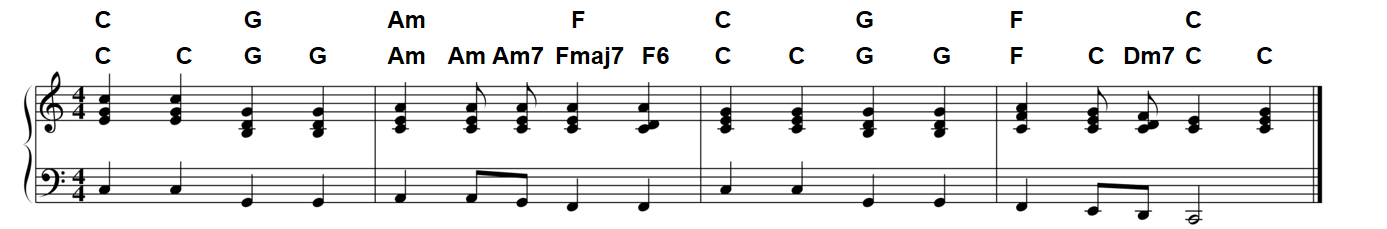

In [11]:
ipd.Image("../img/6.chord_recognition/FMP_C5_F16_score.png", width=800)

- 다음에서는 우선 첫 번째의 단순한 주석을 참조로 사용한다.
- 먼저 음악 녹음을 크로마 벡터의 시퀀스로 변환한다. 그런 다음 템플릿 기반 코드 인식 접근 방식을 적용하여 각 시간 프레임에 대한 화음 라벨을 추정한다. 결과는 이진 time-chord 표현의 형태로 시각화된다.

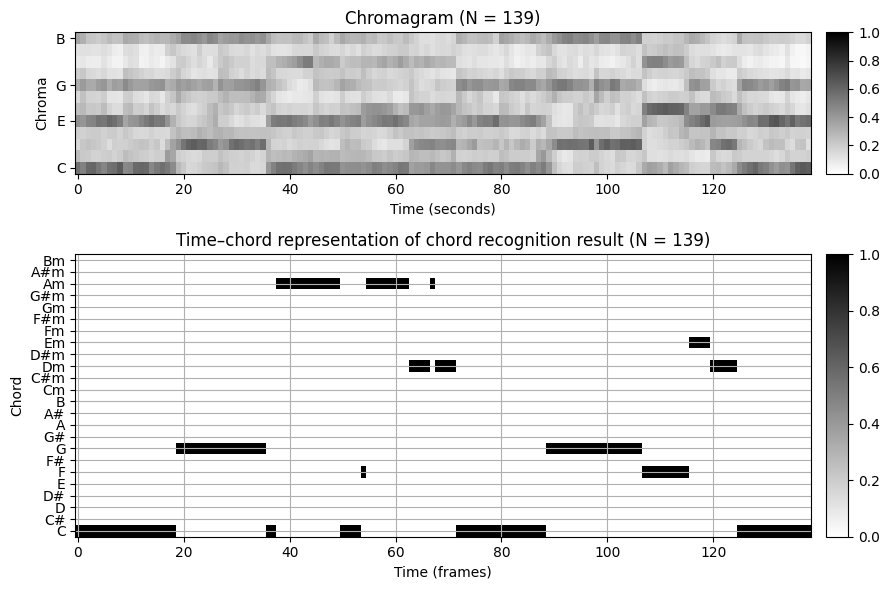

In [12]:
# Compute chromagram
N = 4096
H = 2048
X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=0.1, version='STFT')
#X, Fs_X, x, Fs, x_dur = libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, gamma=100, version='IIR')
#X, Fs_X, x, Fs, x_dur = libfmp.c5.compute_chromagram_from_filename(fn_wav, N=N, H=H, version='CQT')

# Chord recognition
chord_sim, chord_max = chord_recognition_template(X, norm_sim='max')
chord_labels = get_chord_labels()

#Plot
fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [1, 2]}, figsize=(9, 6))

title = 'Chromagram (N = %d)' % X.shape[1]
plot_chromagram(X, Fs=1, ax=[ax[0, 0], ax[0, 1]],
                         chroma_yticks = [0, 4, 7, 11], clim=[0, 1], cmap='gray_r',
                         title=title, ylabel='Chroma', colorbar=True)

title = 'Time–chord representation of chord recognition result (N = %d)' % X.shape[1]
plot_matrix(chord_max, ax=[ax[1, 0], ax[1, 1]], Fs=1, 
                     title=title, ylabel='Chord', xlabel='Time (frames)')
ax[1, 0].set_yticks(np.arange(len(chord_labels)))
ax[1, 0].set_yticklabels(chord_labels)
ax[1, 0].grid()
plt.tight_layout()

- 다음으로 평가에 필요한 참조 주석이 포함된 주석 파일을 사용한다. 시나리오에서 이러한 주석은 라벨이 지정된 세그먼트의 형태로 제공되며, 각각은 시작 및 종료 시간이 $s,t\in\mathbb{R}$(초)및 라벨 $\lambda$인 $(s,t,\lambda)$로 지정된다. 
- 프레임별 평가 측정을 적용하려면 몇 가지 준비가 필요하다.
    * 먼저 **세그먼트 기반 주석**을 크로마 시퀀스에 사용되는 feature rate에 맞게 조정된 **프레임 기반 라벨 시퀀스**로 변환해야 한다. 샘플링에 의해 도입된 시간 그리드가 세그먼트 경계와 일치하지 않을 수 있으므로 이 단계는 trivial하지 않다.
    * 두 번째로, 주석 파일에 사용된 라벨을 자동화된 접근 방식에 사용된 라벨 규칙과 일치하도록 변환해야 할 수 있다. 이 단계는 종종 문제가 되는데, 특히 참조 주석이 다른 sementic level에서 제공될 때(예: $24$ 이상의 장,단3화음 사용) 그렇다.


- 다음 코드 셀에서 원본 주석 파일을 읽고 이를 다양한 형식으로 변환하는 기능을 제공한다.
    * Segment-based annotation with segments (given in seconds)
    * Segment-based annotation with segments (given in indices)
    * Label sequence (specified on the frame level)
    * Encoding of label sequence as segment-based annotation (given in indices) 
    * Encoding of label sequence in form of a binary time&ndash;chord representation

In [13]:
def convert_chord_label(ann):
    """Replace for segment-based annotation in each chord label the string ':min' by 'm'
    and convert flat chords into sharp chords using enharmonic equivalence

    Args:
        ann (list): Segment-based annotation with chord labels

    Returns:
        ann_conv (list): Converted segment-based annotation with chord labels
    """
    ann_conv = copy.deepcopy(ann)

    for k in range(len(ann)):
        ann_conv[k][2] = ann_conv[k][2].replace(':min', 'm')
        ann_conv[k][2] = ann_conv[k][2].replace('Db', 'C#')
        ann_conv[k][2] = ann_conv[k][2].replace('Eb', 'D#')
        ann_conv[k][2] = ann_conv[k][2].replace('Gb', 'F#')
        ann_conv[k][2] = ann_conv[k][2].replace('Ab', 'G#')
        ann_conv[k][2] = ann_conv[k][2].replace('Bb', 'A#')
    return ann_conv


def convert_sequence_ann(seq, Fs=1):
    """Convert label sequence into segment-based annotation

    Args:
        seq (list): Label sequence
        Fs (scalar): Feature rate (Default value = 1)

    Returns:
        ann (list): Segment-based annotation for label sequence
    """
    ann = []
    for m in range(len(seq)):
        ann.append([(m-0.5) / Fs, (m+0.5) / Fs, seq[m]])
    return ann


def convert_chord_ann_matrix(fn_ann, chord_labels, Fs=1, N=None, last=False):
    """Convert segment-based chord annotation into various formats

    Args:
        fn_ann (str): Filename of segment-based chord annotation
        chord_labels (list): List of chord labels
        Fs (scalar): Feature rate (Default value = 1)
        N (int): Number of frames to be generated (by cutting or extending).
            Only enforced for ann_matrix, ann_frame, ann_seg_frame (Default value = None)
        last (bool): If 'True' uses for extension last chord label, otherwise uses nonchord label 'N'
            (Default value = False)

    Returns:
        ann_matrix (np.ndarray): Encoding of label sequence in form of a binary time-chord representation
        ann_frame (list): Label sequence (specified on the frame level)
        ann_seg_frame (list): Encoding of label sequence as segment-based annotation (given in indices)
        ann_seg_ind (list): Segment-based annotation with segments (given in indices)
        ann_seg_sec (list): Segment-based annotation with segments (given in seconds)
    """
    ann_seg_sec, _ = read_structure_annotation(fn_ann)
    ann_seg_sec = convert_chord_label(ann_seg_sec)
    ann_seg_ind, _ = read_structure_annotation(fn_ann, Fs=Fs, index=True)
    ann_seg_ind = convert_chord_label(ann_seg_ind)

    ann_frame = convert_ann_to_seq_label(ann_seg_ind)
    if N is None:
        N = len(ann_frame)
    if N < len(ann_frame):
        ann_frame = ann_frame[:N]
    if N > len(ann_frame):
        if last:
            pad_symbol = ann_frame[-1]
        else:
            pad_symbol = 'N'
        ann_frame = ann_frame + [pad_symbol] * (N-len(ann_frame))
    ann_seg_frame = convert_sequence_ann(ann_frame, Fs=1)

    num_chords = len(chord_labels)
    ann_matrix = np.zeros((num_chords, N))
    for n in range(N):
        label = ann_frame[n]
        # Generates a one-entry only for labels that are contained in "chord_labels"
        if label in chord_labels:
            label_index = chord_labels.index(label)
            ann_matrix[label_index, n] = 1
    return ann_matrix, ann_frame, ann_seg_frame, ann_seg_ind, ann_seg_sec

In [14]:
# Annotations
chord_labels = get_chord_labels(ext_minor='m', nonchord=False)
N_X = X.shape[1]
ann_matrix, ann_frame, ann_seg_frame, ann_seg_ind, ann_seg_sec = convert_chord_ann_matrix(fn_ann, chord_labels, 
                                                                           Fs=Fs_X, N=N_X, last=True)

color_ann = {'C': [1, 0.5, 0, 1], 'G': [0, 1, 0, 1], 
             'Am': [1, 0, 0, 1], 'F': [0, 0, 1, 1], 'N': [1, 1, 1, 1]}

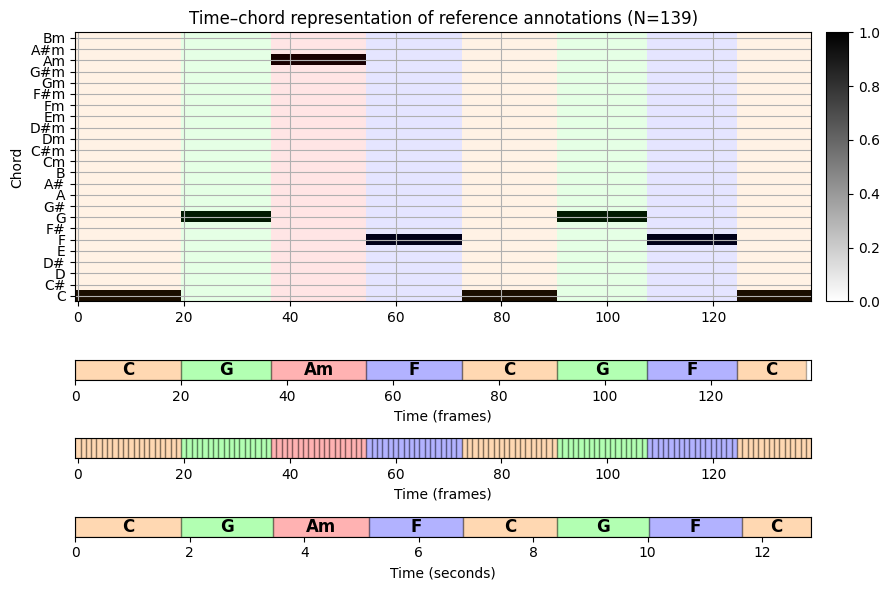

In [16]:
# Plot
cmap = compressed_gray_cmap(alpha=1, reverse=False)
fig, ax = plt.subplots(4, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [4, 0.3, 0.3, 0.3]}, 
                       figsize=(9, 6))

plot_matrix(ann_matrix, ax=[ax[0, 0], ax[0, 1]], Fs=1, 
                     title='Time–chord representation of reference annotations (N=%d)' % ann_matrix.shape[1],
                     ylabel='Chord', xlabel='')
ax[0, 0].set_yticks(np.arange( len(chord_labels) ))
ax[0, 0].set_yticklabels(chord_labels)
plot_segments_overlay(ann_seg_frame, ax=ax[0, 0], 
                               print_labels=False, colors=color_ann, alpha=0.1)
ax[0, 0].grid()
plot_segments(ann_seg_ind, ax=ax[1, 0], time_label='Time (frames)', time_max=N_X,
                       colors=color_ann,  alpha=0.3)
ax[1, 1].axis('off')
plot_segments(ann_seg_frame, ax=ax[2, 0], time_label='Time (frames)', 
                       colors=color_ann,  alpha=0.3, print_labels=False)
ax[2, 1].axis('off')
plot_segments(ann_seg_sec, ax=ax[3, 0], time_max=x_dur, time_label='Time (seconds)',
                       colors=color_ann,  alpha=0.3)
ax[3, 1].axis('off')
plt.tight_layout()

- 이제 평가 지표를 보자. **time-chord 그리드**(집합 $\mathcal{I}$에 해당)를 기반으로 시각화는 TP-, FP- 및 FN-항목을 색상 코드 형식으로 표시한다.

In [18]:
def compute_eval_measures(I_ref, I_est):
    """Compute evaluation measures including precision, recall, and F-measure

    Args:
        I_ref (np.ndarray): Reference set of items
        I_est (np.ndarray): Set of estimated items

    Returns:
        P (float): Precision
        R (float): Recall
        F (float): F-measure
        num_TP (int): Number of true positives
        num_FN (int): Number of false negatives
        num_FP (int): Number of false positives
    """
    assert I_ref.shape == I_est.shape, "Dimension of input matrices must agree"
    TP = np.sum(np.logical_and(I_ref, I_est))
    FP = np.sum(I_est > 0, axis=None) - TP
    FN = np.sum(I_ref > 0, axis=None) - TP
    P = 0
    R = 0
    F = 0
    if TP > 0:
        P = TP / (TP + FP)
        R = TP / (TP + FN)
        F = 2 * P * R / (P + R)
    return P, R, F, TP, FP, FN


def plot_matrix_chord_eval(I_ref, I_est, Fs=1, xlabel='Time (seconds)', ylabel='Chord',
                           title='', chord_labels=None, ax=None, grid=True, figsize=(9, 3.5)):
    """Plots TP-, FP-, and FN-items in a color-coded form in time–chord grid

    Args:
        I_ref: Reference set of items
        I_est: Set of estimated items
        Fs: Feature rate (Default value = 1)
        xlabel: Label for x-axis (Default value = 'Time (seconds)')
        ylabel: Label for y-axis (Default value = 'Chord')
        title: Title of figure (Default value = '')
        chord_labels: List of chord labels used for vertical axis (Default value = None)
        ax: Array of axes (Default value = None)
        grid: If "True" the plot grid (Default value = True)
        figsize: Size of figure (if axes are not specified) (Default value = (9, 3.5))

    Returns:
        fig: The created matplotlib figure or None if ax was given.
        ax: The used axes
        im: The image plot
    """
    fig = None
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=figsize)
        ax = [ax]
    I_TP = np.sum(np.logical_and(I_ref, I_est))
    I_FP = I_est - I_TP
    I_FN = I_ref - I_TP
    I_vis = 3 * I_TP + 2 * I_FN + 1 * I_FP

    eval_cmap = colors.ListedColormap([[1, 1, 1], [1, 0.3, 0.3], [1, 0.7, 0.7], [0, 0, 0]])
    eval_bounds = np.array([0, 1, 2, 3, 4])-0.5
    eval_norm = colors.BoundaryNorm(eval_bounds, 4)
    eval_ticks = [0, 1, 2, 3]

    T_coef = np.arange(I_vis.shape[1]) / Fs
    F_coef = np.arange(I_vis.shape[0])
    x_ext1 = (T_coef[1] - T_coef[0]) / 2
    x_ext2 = (T_coef[-1] - T_coef[-2]) / 2
    y_ext1 = (F_coef[1] - F_coef[0]) / 2
    y_ext2 = (F_coef[-1] - F_coef[-2]) / 2
    extent = [T_coef[0] - x_ext1, T_coef[-1] + x_ext2, F_coef[0] - y_ext1, F_coef[-1] + y_ext2]

    im = ax[0].imshow(I_vis,  origin='lower', aspect='auto', cmap=eval_cmap, norm=eval_norm, extent=extent,
                      interpolation='nearest')
    if len(ax) == 2:
        cbar = plt.colorbar(im, cax=ax[1], cmap=eval_cmap, norm=eval_norm, boundaries=eval_bounds, ticks=eval_ticks)
    elif len(ax) == 1:
        plt.sca(ax[0])
        cbar = plt.colorbar(im, cmap=eval_cmap, norm=eval_norm, boundaries=eval_bounds, ticks=eval_ticks)
    cbar.ax.set_yticklabels(['TN', 'FP', 'FN', 'TP'])
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)
    ax[0].set_title(title)
    if chord_labels is not None:
        ax[0].set_yticks(np.arange(len(chord_labels)))
        ax[0].set_yticklabels(chord_labels)
    if grid is True:
        ax[0].grid()
    return fig, ax, im

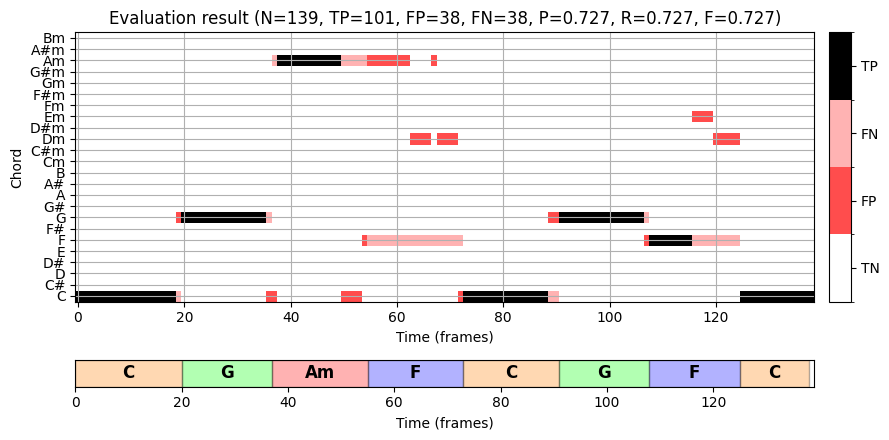

In [21]:
P, R, F, TP, FP, FN = compute_eval_measures(ann_matrix, chord_max)

fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [2, 0.2]}, figsize=(9, 4.5))

title = 'Evaluation result (N=%d, TP=%d, FP=%d, FN=%d, P=%.3f, R=%.3f, F=%.3f)' % (N_X, TP, FP, FN, P,R,F)
plot_matrix_chord_eval(ann_matrix, chord_max, ax=[ax[0, 0], ax[0, 1]], Fs=1, 
                       title=title, ylabel='Chord', xlabel='Time (frames)', chord_labels=chord_labels)

plot_segments(ann_seg_ind, ax=ax[1, 0], time_label='Time (frames)', time_max=N_X,
                       colors=color_ann,  alpha=0.3)
ax[1, 1].axis('off')
plt.tight_layout()
plt.show()

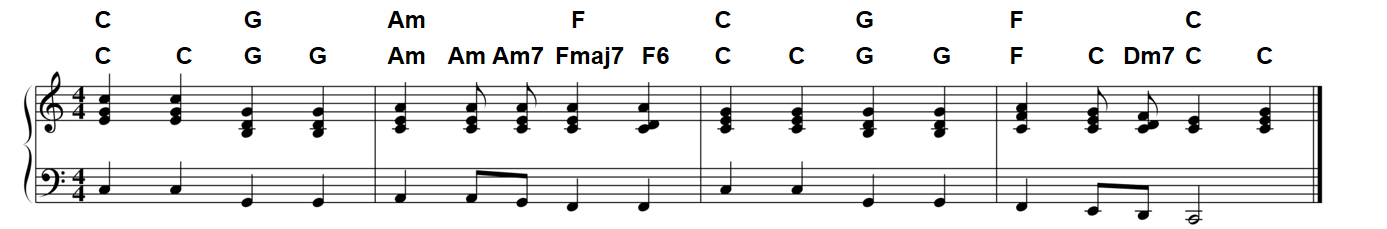

In [24]:
ipd.Image("../img/6.chord_recognition/FMP_C5_F16_score.png", width="800px")

- 이 화음 인식 결과를 자세히 살펴보자. 

- 약 $10.8~\mathrm{Hz}$의 feature rate를 사용하여 $N=139$ 프레임을 얻는다. half-measure 수준의 주석은 녹음의 물리적 시간 축으로 전송되고 오디오 프레임과 일치하도록 추가로 quantized된다. 

- 평가 측정의 경우 $\mathrm{P}=\mathrm{R}=\mathrm{F}=0.727$를 얻는다. 대부분의 잘못된 라벨은 추가 전달 또는 일시 중단된 음으로 인해 **화음 모호성(ambiguities)** 이 있는 프레임에서 발생한다. 이는 더 미세한 수준의 주석을 볼 때 명확해진다. 예를 들어, 두 번째 소절의 $\mathbf{Fmaj7}$ 화음은 4개의 피치 클래스 $\mathrm{F}$, $\mathrm{A}$, $\mathrm{C}$ 및 $\mathrm{E}$으로 구성된다. 음악적으로 $\mathbf{F}$에 가깝지만 네 가지 피치 클래스 중 세 가지가 $\mathbf{Am}$ 화음에서도 발생하기 때문에, 결과적으로 자동화된 절차는 이러한 프레임 중 일부를 $\mathbf{Am}$(및 일부는 $\mathbf{Dm}$)로 잘못 표시했다. 

- 편차의 두 번째 소스는 화음 사이의 **전환 영역(transition region)** 으로, 한 화음의 종료 사운드가 다음 코드의 시작 사운드와 동일한 분석 창에 나타날 수 있다. 예를 들어 첫 번째 소절에서 $\mathbf{C}$ 코드에서 다음 $\mathbf{G}$ 코드로 전환할 때 일부 잘못 분류된 프레임을 발견할 수 있다.

## Non-Chord Labels

- 이전 예에서는 음악 녹음의 모든 프레임이 코드 라벨에 할당되어야 한다고 가정했다. 하지만 실제로 이것이 항상 의미 있는 것은 아니다. 예를 들어, 녹음이 묵음으로 시작하거나 박수로 끝나는 경우, 이 구간에는 의미 있는 코드 주석이 없다. 이러한 경우 해당 프레임은 평가에서 고려하지 않은 상태로 두어야 한다.

- 위에서 이미 설명한 것처럼 **비화음(non-chord) 라벨**을 나타내는 추가 기호 $\mathbf{N}$를 라벨 집합에 추가하여 이 속성을 모델링할 수 있다.

- 따라서 주어진 프레임 $n\in[1:N]$에 대해 의미 있는 참조 화음 라벨이 없는 경우 $\lambda^\mathrm{Ref}_{n}=\mathbf{N}$로 설정힌다.

- 유사하게, 화음 인식기는 화음이 아닌 라벨 $\lambda_{n}=\mathbf{N}$도 출력하도록 수정될 수 있다(예: 크로마 특징과 템플릿 간의 모든 유사성 값이 특정 값 미만인 경우).

- 정밀도, 재현율 및 F-measure을 기반으로 한 평가 측정에서 화음이 아닌 라벨을 단순히 추가 레이블로 취급하지 않았다. 대신 화음이 아닌 라벨이 있는 모든 항목을 평가할 때 이를 **무시**한다.

- 즉, 추정 또는 참조 주석의 이진 시간-화음 표현에는 **갭**이 있을 수 있으며, 특정 프레임은 할당된 화음 라벨 없이 남아 있다.
- 이 경우 정밀도, 재현율 및 F-measure이 다른 값을 생성할 수 있습니다. 이는 참조 주석에서 화음 라벨 $\mathbf{F}$를 화음이 아닌 라벨 $\mathbf{N}$로 대체하는 다음 예에서 확인할 수 있다.

- 결과적으로 이러한 모든 프레임의 추정은 이제 잘못된 것으로 간주되어 FP 항목이 증가한다. 동시에 TP- 및 FN-항목이 감소한다.

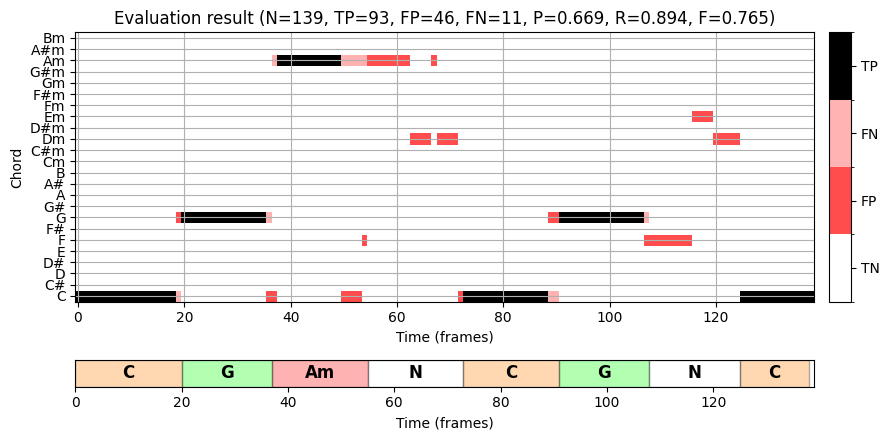

In [25]:
ann_matrix[5, :] = 0
ann_seg_ind[3][2] = 'N'
ann_seg_ind[6][2] = 'N'

P, R, F, TP, FP, FN = compute_eval_measures(ann_matrix, chord_max)


fig, ax = plt.subplots(2, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                          'height_ratios': [2, 0.2]}, figsize=(9, 4.5))

title = 'Evaluation result (N=%d, TP=%d, FP=%d, FN=%d, P=%.3f, R=%.3f, F=%.3f)' % (N_X, TP, FP, FN, P,R,F)
plot_matrix_chord_eval(ann_matrix, chord_max, ax=[ax[0, 0], ax[0, 1]], Fs=1, 
                       title=title, ylabel='Chord', xlabel='Time (frames)', chord_labels=chord_labels)

plot_segments(ann_seg_ind, ax=ax[1, 0], time_label='Time (frames)', time_max=N_X,
                       colors=color_ann,  alpha=0.3)
ax[1,1].axis('off')
plt.tight_layout()
plt.show()

## 화음 인식의 모호함 (Ambiguities in Chord Recognition)

- 다음에서는 자동화된 화음 인식에서 직면하는 가장 일반적인 문제 중 일부를 다룬다.
- 위의 실험에서 알 수 있듯이 서로 다른 화음은 일부 음을 공유함으로써 밀접하게 관련될 수 있다.
- 대부분의 오분류는 **화음 모델의 과도한 단순화(oversimplification)** 로 인한 **화음 모호성(chord ambiguities)** 에서 비롯된다(예: $24$장,단3화음만 고려할 때).
- 이러한 모호성은 다음 그림과 같이 설명된다.

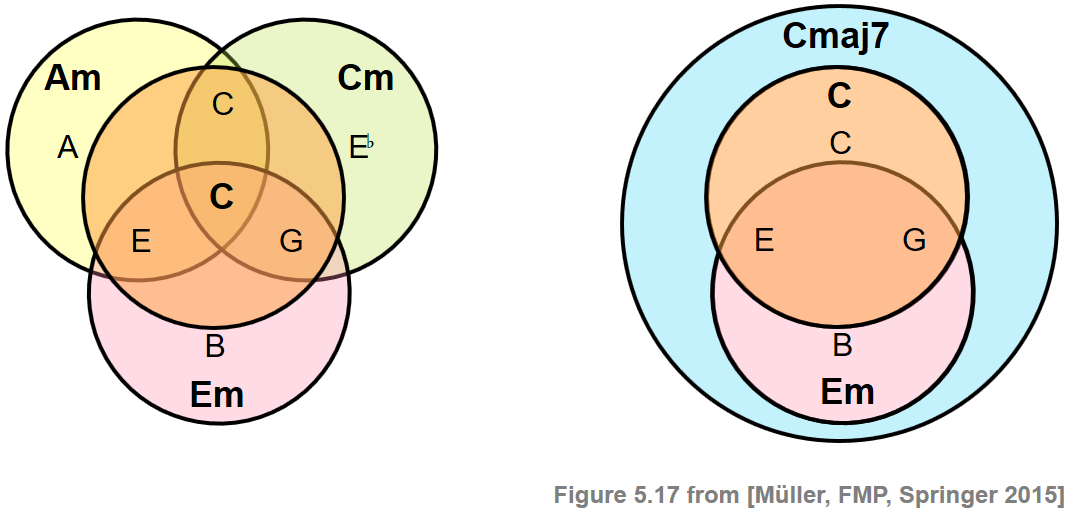

In [27]:
ipd.Image("../img/6.chord_recognition/FMP_C5_F17.png", width="400px")

- 첫 번째 예는 $\mathbf{C}$ 코드가 각각 $\mathbf{Am}$, $\mathbf{Cm}$ 및 $\mathbf{Em}$ 코드와 두 개의 음을 공유하는 반면, 두 번째 예는 $\mathbf{Cmaj7}$ 코드가 $\mathbf{C}$ 및 $\mathbf{Em}$ 코드를 포함함을 나타낸다.

- 이때 화음 라벨의 집합을 확장하여 오분류 문제를 완화할 수 있다. 예를 들어 장,단3화음 외에도 장7도화음에 해당하는 화음 템플릿을 도입할 수도 있다. 그러나 단점으로는 가능한 화음의 수를 늘리면 분류 단계에서 혼동 확률도 높아진다는 것이다.


- 또 다른 문제는 녹음된 음악의 음향적(acoustic) 특성에서 비롯된다.
- 특히, **음향 모호성**은 부분음(harmonic partials)이 도입되어 화음 인식기의 결과에 상당한 영향을 미칠 수 있다. 예를 들어, 악기에서 $\mathrm{C3}$ 단일 음을 연주하면, 크로마그램 표현 결과에서 $\mathrm{G}$-band(3차 고조파) 또는 $\mathrm{E}$-band(5차 고조파)에 상당한 에너지가 발생할 수 있다.
- 이것은 종종 **major-minor 혼동**으로 알려진 문제를 야기한다.


- 가정된 중심 주파수에서 벗어나면 크로마 기반 특징과 같은 음악적으로 정보가 있는 오디오 기능의 품질이 심각하게 저하될 수 있다.
- 이러한 **튜닝 문제**는 의도적으로 발생할 수 있지만(예: 오케스트라가 다른 참조 튜닝을 사용한 경우), 재생 속도 수정 또는 다른 후처리 작업의 적용으로 인해 발생할 수도 있다.

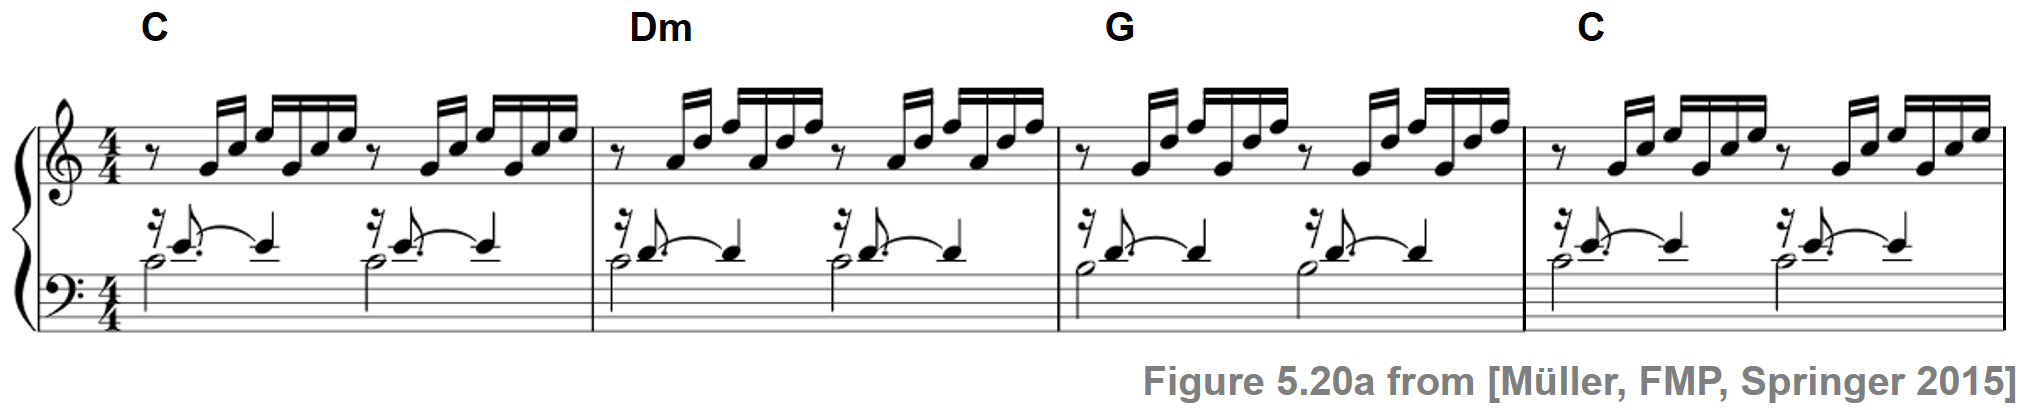

In [31]:
ipd.display(ipd.Image("../img/6.chord_recognition/FMP_C5_F20a.png", width="600px"))
ipd.display(ipd.Audio("../data_FMP/FMP_C5_F20_Bach_BWV846-mm1-4_Fischer.wav"))

- 이 예에서 각 반음(half-measure)은 저음(bass note)으로 시작한다. 그런 다음 다른 음표가 합류하여 점차 전체 화음의 소리를 만든다. 
- 음을 동시에 연주하지 않더라도 끊어진 화음 전체가 하나의 화성 단위로 인식될 수 있다. 
- 신호를 짧은 프레임으로 자르고 각 프레임을 개별적으로 분류하는 기본적인 **프레임 수준**의 화음 인식 절차의 경우 이러한 끊어진 화음은 문제가 된다. 

- 다음 코드 셀에서는 입력 크로마그램을 계산하는 데 사용되는 다양한 창 크기에 대한 결과를 보여주는 화음 인식을 보여준다.

In [32]:
def experiment_chord_recognition_feature(fn_wav, fn_ann, color_ann, N_chroma, H_chroma, gamma=1,
                                         version='STFT'):
    # Compute chromagram
    X, Fs_X, x, Fs, x_dur = compute_chromagram_from_filename(fn_wav, N=N_chroma, H=H_chroma, 
                                                                       gamma=gamma, version=version)
    N_X = X.shape[1]

    # Chord recogntion
    chord_sim, chord_max = chord_recognition_template(X, norm_sim='max')
    chord_labels = get_chord_labels(nonchord=False)

    # Annotations
    chord_labels = get_chord_labels(ext_minor='m', nonchord=False)
    ann_matrix, ann_frame, ann_seg_frame, ann_seg_ind, ann_seg_sec = \
        convert_chord_ann_matrix(fn_ann, chord_labels, Fs=Fs_X, N=N_X, last=True)

    P, R, F, TP, FP, FN = compute_eval_measures(ann_matrix, chord_max)

    fig, ax = plt.subplots(3, 2, gridspec_kw={'width_ratios': [1, 0.03], 
                                              'height_ratios': [1, 2, 0.2]}, figsize=(9, 6))

    title = title='Chromagram with window size = %.3f (seconds)' % (N_chroma / Fs)
    plot_chromagram(X, ax=[ax[0, 0], ax[0, 1]], Fs=1, clim=[0, 1], xlabel='', title=title)
    plot_segments_overlay(ann_seg_frame, ax=ax[0, 0], 
                                   print_labels=False, colors=color_ann, alpha=0.1)

    title = 'Evaluation result (N=%d, TP=%d, FP=%d, FN=%d, F=%.3f)' % (N_X, TP, FP, FN, F)
    plot_matrix_chord_eval(ann_matrix, chord_max, ax=[ax[1, 0], ax[1, 1]], Fs=1, 
                         title=title, ylabel='Chord', xlabel='Time (frames)', chord_labels=chord_labels)

    plot_segments(ann_seg_ind, ax=ax[2, 0], time_label='Time (frames)', time_max=N_X,
                           colors=color_ann,  alpha=0.3)
    ax[2, 1].axis('off')
    plt.tight_layout()
    plt.show()

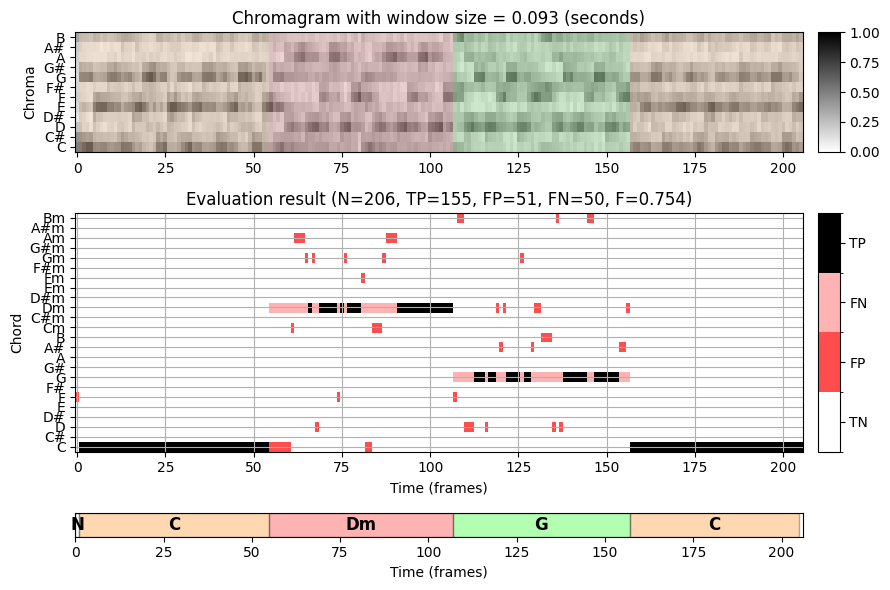

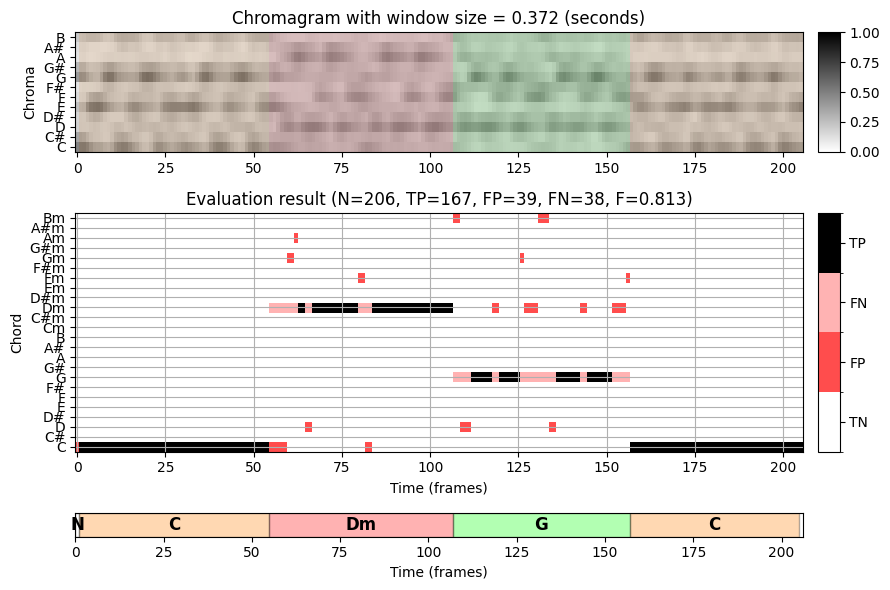

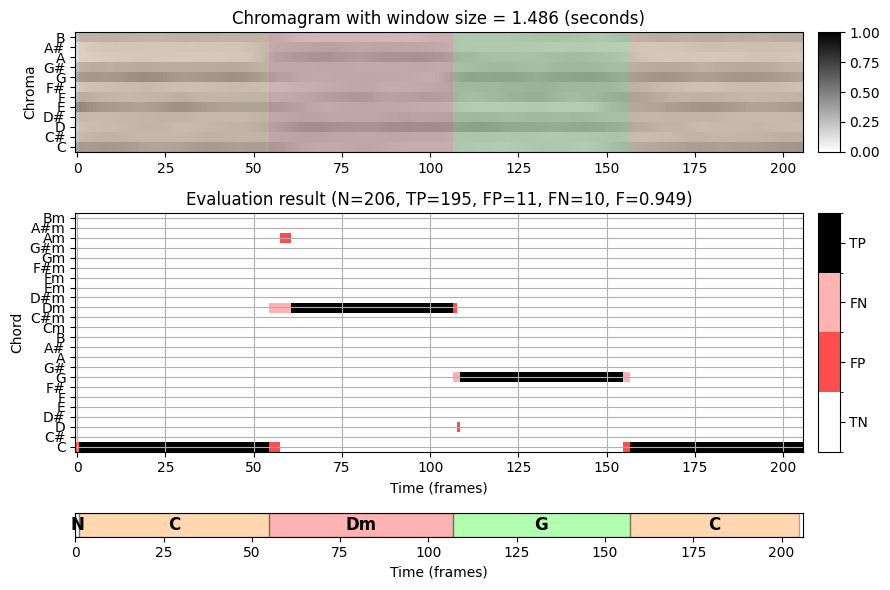

In [33]:
fn_wav = "../data_FMP/FMP_C5_F20_Bach_BWV846-mm1-4_Fischer.wav"
fn_ann = "../data_FMP/FMP_C5_F20_Bach_BWV846-mm1-4_Fischer_ChordAnnotations.csv"

color_ann = {'C': [1, 0.5, 0, 1], 'G': [0, 1, 0, 1], 'Dm': [1, 0, 0, 1], 'N': [1, 1, 1, 1]}

experiment_chord_recognition_feature(fn_wav, fn_ann, color_ann, N_chroma=2048, H_chroma=1024)
experiment_chord_recognition_feature(fn_wav, fn_ann, color_ann, N_chroma=2048*4, H_chroma=1024)
experiment_chord_recognition_feature(fn_wav, fn_ann, color_ann, N_chroma=2048*16, H_chroma=1024)

- 바흐 녹음에서 16분음표는 대략 $150~\mathrm{msec}$의 길이를 가진다.
- 따라서 약 $90~\mathrm{msec}$ 기간의 분석 창을 사용하면 각 크로마 프레임은 최대 하나의 음표 시작점을 포함한다.
- 각 음표의 소리가 기보된 길이보다 훨씬 더 오래 지속될 수 있지만 각 프레임의 화성은 단 하나 또는 두 개의 음(부분음 포함)에 의해 지배된다. 이것은 첫 번째 설정(작은 창 크기)의 인식 결과에서 오분류 및 많은 화음 라벨 변경을 설명한다.

- 바흐 예에서 화음 인식 결과를 개선하기 위한 확실한 전략은 주석의 절반 또는 측정 수준에 더 잘 일치하는 더 큰 창 크기를 사용하는 것이다. 이는 두 번째 설정(중간 창 크기, $372~\mathrm{msec}$) 및 세 번째 설정(큰 창 크기, $1486~\mathrm{msec}$)에서 확인할 수 있다.

- 그러나 단점으로 더 큰 분석 창은 서로 다른 화음 사이의 원래의 날카로운 전환을 부드럽게 하여, 화음 변경 시 문제를 일으킬 수 있다.

**마치며**

- 음악 처리 작업에 대한 평가 자체는 매우 중요한 주제이다. 우선, 전문가가 생성하는 참조 주석이 필요하며, 이러한 주석은 일반적으로 전문가의 **주관적인 결정**을 기반으로 한다. 또한 이러한 주석의 사양에는 단순화가 필요할 수 있다(예: 허용되는 코드 유형 선택). 마지막으로 알고리즘의 출력 형식에 맞게 참조 주석을 변환해야 할 수도 있다. 예를 들어, 물리적 시간축(초 단위)을 샘플링된 시간축(프레임 단위)으로 변환할 수 있다. 음악적 모호성과 주석자에 따른 선택 외에도 이러한 기술적 변환은 평가 프로세스에 추가적인 불확실성을 가져올 수 있다. 구체적인 예로 화음 인식 시나리오에서 대략 $500~\mathrm{msec}$마다 화음이 변경되는 음악 녹음을 처리한다고 가정하자. 또한 특징 해상도가 대략 $50~\mathrm{msec}$(초당 $20$ 크로마 기능)이라고 가정하자. 그런 다음 quantized된 시간 축에서 평가할 때 프레임의 거의 $10\,\%$에 대해 quantization 모호성이 있을 수 있으며, 이는 평가 측정에 대략 $5\,\%$ 영향을 미칠 수 있다. 
- 요약하면 다음 사항을 염두에 두어야 한다.
    * 참조 주석을 항상 신뢰하지 말 것!
    * 기본 모델 가정을 명시적으로 지정하고 그 영향을 이해할 것
    * 변환 단계(예: 시간 샘플링)와 도입된 모호성을 이해할 것